## 7.5 CNN 구현하기  
 <img style="float: left;" src="equations_and_figures/fig%207-23.png" width="600">

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.2995945606733956
=== epoch:1, train acc:0.132, test acc:0.159 ===
train loss:2.2966709429822094
train loss:2.2923729472287606
train loss:2.2892664287999125
train loss:2.2802225838781958
train loss:2.2713717490806875
train loss:2.2578431933919756
train loss:2.233756358082819
train loss:2.20541096344616
train loss:2.1864489829679195
train loss:2.1668491077656498
train loss:2.1194882223670817
train loss:2.0577395399491247
train loss:1.9888877807438186
train loss:1.9437071664158654
train loss:1.9080515928715416
train loss:1.8272754066802557
train loss:1.7768359361853123
train loss:1.7238716712616338
train loss:1.560290872041316
train loss:1.4714613143704336
train loss:1.369691546895194
train loss:1.4823035825196422
train loss:1.2346573488197654
train loss:1.222113999765385
train loss:1.0762767962860273
train loss:1.1904376336421898
train loss:0.9495220447907274
train loss:1.0590881310217206
train loss:0.9604134100623477
train loss:0.857120372641844
train loss:0.967379192448520

train loss:0.19208482789722894
train loss:0.26498871051988687
train loss:0.2096404170557763
train loss:0.15901096143006088
train loss:0.18051085849043724
train loss:0.22924713828636023
train loss:0.3218648434150269
train loss:0.22173752354392245
train loss:0.3022714923860268
train loss:0.09861459777845387
train loss:0.23865452562837955
train loss:0.15310495915147915
train loss:0.2745005999566585
train loss:0.24081635388271455
train loss:0.18523749156794317
train loss:0.18806905910030866
train loss:0.16082548417419001
train loss:0.2572743293485067
train loss:0.15686294695229513
train loss:0.16426737427887977
train loss:0.4147429546526486
train loss:0.17371764372967718
train loss:0.22511101944956477
train loss:0.16967907245749125
train loss:0.27404242209756563
train loss:0.294222622648407
train loss:0.24311543114725137
train loss:0.2925498716124577
train loss:0.18627114915151907
train loss:0.2034876542334974
train loss:0.24635814314694796
train loss:0.30036390980726063
train loss:0.27012

train loss:0.1016924016537147
train loss:0.0900864910737324
train loss:0.10361743252123803
train loss:0.17319532626223647
train loss:0.17127318880093412
train loss:0.19660760375925113
train loss:0.2279430775136164
train loss:0.07570209179856784
train loss:0.09845324405509855
train loss:0.06066421576150873
train loss:0.13643522616018852
train loss:0.15096809001170633
train loss:0.11732700862072397
train loss:0.09146433184062451
train loss:0.07034439056255065
train loss:0.2036997171708679
train loss:0.19044490863070324
train loss:0.0775490236032983
train loss:0.0846347822361419
train loss:0.15608578401881065
train loss:0.07321751217148764
train loss:0.07463922995149866
train loss:0.205404266245777
train loss:0.0927579310238089
train loss:0.09685336637740258
train loss:0.1220402911474484
train loss:0.09526670913604264
train loss:0.07199369459445587
train loss:0.21923874183612577
train loss:0.12745252164610613
train loss:0.15026605422860645
train loss:0.12866414372679358
train loss:0.05239

train loss:0.052671108749497215
train loss:0.06546977879914705
train loss:0.033112163724999484
train loss:0.05378883541749326
train loss:0.1842287728177389
train loss:0.06749880041778875
train loss:0.15401957035061278
train loss:0.07468317976029203
train loss:0.09059361875083224
train loss:0.028141807333091604
train loss:0.0983973749256697
train loss:0.07655788281275475
train loss:0.08847984201481332
train loss:0.09402812612801031
train loss:0.07611084210424454
train loss:0.06459650933001058
train loss:0.1412513244499957
train loss:0.057356979811350295
train loss:0.04652641981681183
train loss:0.0871207514801059
train loss:0.08889999268667498
train loss:0.10110806919469016
train loss:0.10704321770623211
train loss:0.08093200341105795
train loss:0.10132325364320381
train loss:0.17039986577637994
train loss:0.059362119074561515
train loss:0.06682911325325297
train loss:0.12400052763166436
train loss:0.14091031204552393
train loss:0.08857380889175676
train loss:0.057371966090160154
train 

train loss:0.0560579056803114
train loss:0.040267960104801576
train loss:0.13902982863615831
train loss:0.08216349489240715
train loss:0.17517873254318073
train loss:0.03488607880531547
train loss:0.08657027877759463
train loss:0.14928778788649782
train loss:0.055296782019624076
train loss:0.05096797830833328
train loss:0.04083520516795575
train loss:0.04282041730992112
train loss:0.07024934009668295
train loss:0.06259492358400873
train loss:0.026924082524137603
train loss:0.0966443421368898
train loss:0.0444225591354835
train loss:0.09663696936746678
train loss:0.11703770150067273
train loss:0.04121026222523527
train loss:0.04998885578031066
train loss:0.043823564094147
train loss:0.06725600208779248
train loss:0.095459458959606
train loss:0.06646297165847007
train loss:0.06199982572179908
train loss:0.06614585124879703
train loss:0.03586942112242277
train loss:0.043961719616852565
train loss:0.13729940779051378
train loss:0.04268383262186617
train loss:0.13015640365485218
train loss:

train loss:0.03788894342778095
train loss:0.04200108877973002
train loss:0.08631630725312714
train loss:0.06445336614840126
train loss:0.11628976325915939
train loss:0.03142272981193425
train loss:0.04707364186180451
train loss:0.06980968103150353
train loss:0.05759959313653777
train loss:0.02335447437006763
train loss:0.07245955300162682
train loss:0.06725289135803036
train loss:0.04339538854704335
train loss:0.04777572002931632
train loss:0.023208437876270964
train loss:0.035601081840405294
train loss:0.02715290420498405
train loss:0.10762968866155687
train loss:0.048382232738250534
train loss:0.033292850974164886
train loss:0.01591504328785384
train loss:0.04438896938181841
train loss:0.023205803417260144
train loss:0.07790797582736811
train loss:0.04754250686448223
train loss:0.045561889009573475
train loss:0.08831006906806667
train loss:0.05645027784677963
train loss:0.02017013624395088
train loss:0.03894061874946233
train loss:0.05466162400569854
train loss:0.03957836583669042
tr

train loss:0.07492673987881915
train loss:0.03353815286924107
train loss:0.037221130030262145
train loss:0.026942036337110967
train loss:0.03234242723121773
train loss:0.015104902560961747
train loss:0.10106717855852654
train loss:0.03231468030001132
train loss:0.014732649734237943
train loss:0.05221997120391898
train loss:0.03146740761250633
train loss:0.06231579349974013
train loss:0.021974563244433185
train loss:0.038445042283036246
train loss:0.016174254876043945
train loss:0.026380543726007715
train loss:0.1509043829350858
train loss:0.20417458284213652
train loss:0.03745519641001279
train loss:0.00622282159263489
train loss:0.03337757812100681
train loss:0.059307921312634126
train loss:0.10077380527744052
train loss:0.027331565527733196
train loss:0.05898202518805376
train loss:0.012873394424847539
train loss:0.017447995284667027
train loss:0.027570371827478526
train loss:0.06400800498035975
train loss:0.06535531375511519
train loss:0.10302456012905627
train loss:0.03859812874141

train loss:0.020742025178771148
train loss:0.04872214384665494
train loss:0.052186108932873114
train loss:0.09533313133210744
train loss:0.053990265269006556
train loss:0.03158013992845777
train loss:0.08345620963220414
train loss:0.025224580232268253
train loss:0.015944814079344238
train loss:0.019713543921536944
train loss:0.034860065351080244
train loss:0.06255845853305181
train loss:0.03297722750543846
train loss:0.04058309940298261
train loss:0.11320961308962371
train loss:0.018538347814867132
train loss:0.04140492017360879
train loss:0.10231138359763647
train loss:0.06938663956434744
train loss:0.02456205441333176
train loss:0.02844678017882805
train loss:0.046699581425084825
train loss:0.021267497484062963
train loss:0.014903013519855282
train loss:0.01820316590220644
train loss:0.04160619087217711
train loss:0.02706980100881796
train loss:0.060624429381482915
train loss:0.06742669058184683
train loss:0.01665851030104461
train loss:0.04558262630870608
train loss:0.05991120215660

train loss:0.007952855375106267
train loss:0.04850087684064024
train loss:0.03129453001910582
train loss:0.01415573368686268
train loss:0.01474528225557072
train loss:0.018300803817819324
train loss:0.026289475677527926
train loss:0.04060240672371462
train loss:0.02346918873235916
train loss:0.052687385257593
train loss:0.01933021998429086
train loss:0.039862021267838305
train loss:0.010145452903288716
train loss:0.03245220222269896
train loss:0.050838007515975184
train loss:0.023164293519509615
train loss:0.00979097112172256
train loss:0.022308062306019786
train loss:0.023808569869591102
train loss:0.01630955590952287
train loss:0.031084107183944925
train loss:0.06911960641806073
train loss:0.05261267303347833
train loss:0.012843137615013558
train loss:0.010959465492197553
train loss:0.046539828861095485
train loss:0.09108893339179897
train loss:0.012574243111614425
train loss:0.03158266725249852
train loss:0.04722275904837961
train loss:0.008081522282940574
train loss:0.0397268399228

train loss:0.03205837911766288
train loss:0.09977770029874894
train loss:0.02401274882811336
train loss:0.012415643437722309
train loss:0.020167141016109343
train loss:0.016618360287236577
train loss:0.013306737879476758
train loss:0.023478501497011358
train loss:0.02991676557567058
train loss:0.10058690157678121
train loss:0.017036030437790478
train loss:0.04755842954773001
train loss:0.04975264047441084
train loss:0.017167946411055998
train loss:0.044225650953286066
train loss:0.037404497313552575
train loss:0.01523925663528622
train loss:0.01059595144743153
train loss:0.01576781174355955
train loss:0.035905070203893226
train loss:0.02639012349962666
train loss:0.028175386186228623
train loss:0.016858556809910864
train loss:0.03098503974436754
train loss:0.016770765337825493
train loss:0.009790898142332187
train loss:0.020654665542860925
train loss:0.019605886629333647
=== epoch:5, train acc:0.987, test acc:0.98 ===
train loss:0.019190566345496964
train loss:0.03921136859688043
train

train loss:0.01610963314347054
train loss:0.03243418648935049
train loss:0.01700611106922826
train loss:0.025983294591999634
train loss:0.026488984990189098
train loss:0.040138541850472054
train loss:0.004286496894219725
train loss:0.01787443907338064
train loss:0.05404321962629993
train loss:0.0174097316845726
train loss:0.005671357751802393
train loss:0.10109309352886164
train loss:0.011813937459797091
train loss:0.03145921140022881
train loss:0.05697231536119963
train loss:0.008185325614096925
train loss:0.02179151328243121
train loss:0.03770429021630974
train loss:0.0034759638854286886
train loss:0.009992218809661434
train loss:0.0204255909631707
train loss:0.03777794790052351
train loss:0.007109947007155841
train loss:0.020849146670318182
train loss:0.021768274603362264
train loss:0.015457740486431846
train loss:0.014643902991687446
train loss:0.05681892139040752
train loss:0.016111982459399682
train loss:0.0216275975638451
train loss:0.027227884908513203
train loss:0.014422212790

train loss:0.015212480028661123
train loss:0.054609454930858864
train loss:0.011637267165797958
train loss:0.017251407327608874
train loss:0.09785305443447223
train loss:0.033788240281865126
train loss:0.022406756069983057
train loss:0.008270379165423202
train loss:0.006351899219889942
train loss:0.005841576044885815
train loss:0.031912954199154416
train loss:0.04131657035155195
train loss:0.05812298112520097
train loss:0.07657238923621225
train loss:0.00789720067798036
train loss:0.00893502955183007
train loss:0.03651269421847175
train loss:0.10310689920931529
train loss:0.015392475725382644
train loss:0.021332257890345527
train loss:0.00819602201624468
train loss:0.006427753591626425
train loss:0.0870597579403084
train loss:0.01427608424322737
train loss:0.04454515735716088
train loss:0.008943692965686674
train loss:0.028132309829841176
train loss:0.01319435473141991
train loss:0.01022883294573935
train loss:0.010313889285510712
train loss:0.014484502392692646
train loss:0.0544348930

train loss:0.01306851308958883
train loss:0.03374469507228213
train loss:0.006938820742487472
train loss:0.009363548164808624
train loss:0.00893457286251192
train loss:0.035152592190990054
train loss:0.011289523235684306
train loss:0.024296093573098143
train loss:0.066630202586436
train loss:0.04232455437399452
train loss:0.009222268930304235
train loss:0.01549507893987143
train loss:0.00932443439578438
train loss:0.05753884673302441
train loss:0.013680828513217225
train loss:0.040522522615991576
train loss:0.011930359428445652
train loss:0.016881710232728834
train loss:0.007358054964188572
train loss:0.013159531941602251
train loss:0.016757263900523595
train loss:0.016738688690276202
train loss:0.016267534211097515
train loss:0.008429729909795966
train loss:0.020725071467297962
train loss:0.010193148660755446
train loss:0.015917455423469385
train loss:0.025476428151894187
train loss:0.008546470747678413
train loss:0.08361301119316902
train loss:0.034015906626381605
train loss:0.007207

train loss:0.009659400630121382
train loss:0.02087373972531189
train loss:0.04822507951864381
train loss:0.009564289908115654
train loss:0.04610396263512581
train loss:0.02369567888485171
train loss:0.040842417883956934
train loss:0.0035299921246836996
train loss:0.029163997633336648
train loss:0.0055428362739651784
train loss:0.013217840138137402
train loss:0.009733762151981056
train loss:0.04223180415382685
train loss:0.011946157547965566
train loss:0.013151990423948958
train loss:0.06820154991930362
train loss:0.020250093302911873
train loss:0.02346663234364513
train loss:0.011143505228796596
train loss:0.053961322624736956
train loss:0.018844559045390546
train loss:0.022776503329994112
train loss:0.0190509006206888
train loss:0.013518606943228578
train loss:0.051627507391884785
train loss:0.004102276215725311
train loss:0.0022488655248287005
train loss:0.009716768554847396
train loss:0.009689644522139794
train loss:0.008199991472269018
train loss:0.041144400238227144
train loss:0.0

train loss:0.05660046012261099
train loss:0.010482817180597195
train loss:0.019178819921587795
train loss:0.011443763445199547
train loss:0.005544713261938568
train loss:0.0036627928178359897
train loss:0.004468281038593359
train loss:0.003109692973119128
train loss:0.01913087966008954
train loss:0.07107280757582685
train loss:0.0009626996121220755
train loss:0.010000311704750391
train loss:0.0051047791308199844
train loss:0.002754113973178646
train loss:0.019943660991331536
train loss:0.009317808552109669
train loss:0.011971274869941491
train loss:0.00826783872799774
train loss:0.04770470967916699
train loss:0.004106857279594429
train loss:0.018352942096522492
train loss:0.009095635089350747
train loss:0.041087197178070946
train loss:0.021908631014317795
train loss:0.007521719394709961
train loss:0.010649287607951769
train loss:0.054534391004013166
train loss:0.008575509698569421
train loss:0.036469601049212756
train loss:0.011350021328510412
train loss:0.020446045450259298
train loss

train loss:0.0297759257791556
train loss:0.006359881353276238
train loss:0.00935155317010459
train loss:0.018105224250919226
train loss:0.003963190497455312
train loss:0.007144422738994757
train loss:0.010941645980021533
train loss:0.0386354296132223
train loss:0.0024545589668789995
train loss:0.03250529682182756
train loss:0.005406416133292002
train loss:0.0022468693232458475
train loss:0.010279478295217115
train loss:0.0030003506189817154
train loss:0.009197864140734402
train loss:0.004319228379386873
train loss:0.005248986470357053
train loss:0.0032845810511490784
train loss:0.020106233020844303
train loss:0.005125621342628724
train loss:0.011061074559922786
train loss:0.0020267103275296576
train loss:0.002372734792935931
train loss:0.020998388183603747
train loss:0.0018154232428951402
train loss:0.024450210889866555
train loss:0.009891416712731103
train loss:0.005277712068830643
train loss:0.013408397341959637
train loss:0.019157616700172485
train loss:0.012974573926217047
train lo

train loss:0.007541124341013941
train loss:0.04498044183180488
train loss:0.007086550537968669
train loss:0.016558088329014713
train loss:0.025702939028100707
train loss:0.00976050117610516
train loss:0.015300364687685648
train loss:0.002548258876241286
train loss:0.027800547240532714
train loss:0.03974082966607091
train loss:0.018271197585094733
train loss:0.0020485317077012354
train loss:0.009230591297976725
train loss:0.0421432506684167
train loss:0.05781047781135447
train loss:0.0052385838885265976
train loss:0.009862941555602939
train loss:0.01016471530062729
=== epoch:8, train acc:0.99, test acc:0.988 ===
train loss:0.002982745728674523
train loss:0.005066012880740216
train loss:0.005379743599906292
train loss:0.00841648673818699
train loss:0.02052562185987071
train loss:0.003442372132232879
train loss:0.0026067553419414735
train loss:0.012017890047352322
train loss:0.01277137680009164
train loss:0.00808737299370543
train loss:0.0007321385335868431
train loss:0.005401749862526296

train loss:0.0032228635865072823
train loss:0.025947986580777665
train loss:0.011414077746611856
train loss:0.07228434173001679
train loss:0.0024887244113384853
train loss:0.0017488318038376591
train loss:0.011821795546438236
train loss:0.006211774363403508
train loss:0.00471864741909279
train loss:0.007293886707343228
train loss:0.012986467483248831
train loss:0.02514151593635681
train loss:0.007716593299940032
train loss:0.006378094658219306
train loss:0.01956000450854857
train loss:0.008435776935722762
train loss:0.0037299222226661317
train loss:0.04629656824015182
train loss:0.021599376769251652
train loss:0.00982467275271221
train loss:0.016075028788239635
train loss:0.022082644281361564
train loss:0.003865874111048866
train loss:0.028448373975968257
train loss:0.008453686234745518
train loss:0.007179199724997774
train loss:0.005375281162898943
train loss:0.028010512515261498
train loss:0.006593392873701008
train loss:0.002823466311849665
train loss:0.0022717003040526366
train los

train loss:0.00482111494709282
train loss:0.004634618270474209
train loss:0.024301913632358372
train loss:0.013130337697935281
train loss:0.020054379689923466
train loss:0.005034081303872911
train loss:0.0028045835671798944
train loss:0.04857361354350417
train loss:0.00225365407409652
train loss:0.004820810345160847
train loss:0.007822356333700117
train loss:0.002590203725041528
train loss:0.001756366842780929
train loss:0.004624548204713653
train loss:0.017204635663336118
train loss:0.005820236490844307
train loss:0.0090251102453873
train loss:0.029869555748823176
train loss:0.006515619712066746
train loss:0.011451552788737303
train loss:0.0269636572698978
train loss:0.04463672314299573
train loss:0.005113846192775479
train loss:0.0099777067528652
train loss:0.012025606883087842
train loss:0.028092499692557275
train loss:0.00949473894271825
train loss:0.003948375848825185
train loss:0.01415217601381753
train loss:0.0037548295709769488
train loss:0.0023591134317078894
train loss:0.0106

train loss:0.004404444415515365
train loss:0.014897905288581344
train loss:0.02489846723416072
train loss:0.028434001505696953
train loss:0.0077338837983720295
train loss:0.003122214919618379
train loss:0.017514053534885343
train loss:0.0057131124988595615
train loss:0.009562847785232524
train loss:0.005308137990955659
train loss:0.0028213920872194823
train loss:0.003769555285668211
train loss:0.045308648467575666
train loss:0.015714592823231625
train loss:0.00794633348173948
train loss:0.006986597729900459
train loss:0.0026188048086070127
train loss:0.010269848563988486
train loss:0.009066209210418842
train loss:0.030350049988009192
train loss:0.0052681747994878245
train loss:0.0030546327447319
train loss:0.005077351816042063
train loss:0.011773205517563385
train loss:0.026696261188709807
train loss:0.004187489590157006
train loss:0.0065607238075162345
train loss:0.020678671998514576
train loss:0.010044751556650668
train loss:0.00455888755973012
train loss:0.004754868764076132
train l

train loss:0.009464680098745454
train loss:0.005891293036678945
train loss:0.00933932391235698
train loss:0.0028541742984527687
train loss:0.004699852111533316
train loss:0.0011560989368964091
train loss:0.023433531729664416
train loss:0.01680258814649044
train loss:0.0034884532039863407
train loss:0.004289685080464515
train loss:0.013178952520138358
train loss:0.0020006922342861617
train loss:0.0022027567779523906
train loss:0.014585849452877242
train loss:0.0033244425336024924
train loss:0.004849929180333684
train loss:0.004098023865599775
train loss:0.004026597209013419
train loss:0.010674888929723746
train loss:0.009967273327392055
train loss:0.004702647366123089
train loss:0.005320655763674766
train loss:0.0025978474606568303
train loss:0.022140260472424355
train loss:0.008450807800421992
train loss:0.011898632826097245
train loss:0.00728562774554675
train loss:0.048824159033898896
train loss:0.08272502358098471
train loss:0.0009809784477577035
train loss:0.02248592458213529
train

train loss:0.004908340648175755
train loss:0.004416530194224582
train loss:0.005595093511602728
train loss:0.004657508500942949
train loss:0.005314591482415302
train loss:0.005550399641947119
train loss:0.001319582946399749
train loss:0.007275952902548388
train loss:0.0018467072745895095
train loss:0.01824838943825709
train loss:0.002228577156300834
train loss:0.046389439045705444
train loss:0.026126838166041316
train loss:0.012759905710665527
train loss:0.007730347971617067
train loss:0.05460303242617746
train loss:0.03517584437180182
train loss:0.00947971796450338
train loss:0.006270234479748138
train loss:0.005645356903117412
train loss:0.0010013641836601197
train loss:0.0011736127656173912
train loss:0.03772014903396112
train loss:0.014052574443565733
train loss:0.0007378847817125375
train loss:0.005777882567408585
train loss:0.0035050925423748642
train loss:0.008717630661720835
train loss:0.0063702738125357575
train loss:0.015468924064366365
train loss:0.0037253600378542623
train 

train loss:0.0027415220463843783
train loss:0.02274942179020328
train loss:0.007950352610301754
train loss:0.0023672515215845966
train loss:0.004411773622472791
train loss:0.010009873638682117
train loss:0.002941410770502591
train loss:0.0073017346564855845
train loss:0.005148839058503142
train loss:0.0037018954567616794
train loss:0.010263410627381729
train loss:0.0034799673753768
train loss:0.00900837391528936
train loss:0.0049723085723779
train loss:0.00619779892323108
train loss:0.004857596116645435
train loss:0.015223046636529758
train loss:0.0060690775898739665
train loss:0.015519770049784885
train loss:0.003238109863022194
train loss:0.015043508443361225
train loss:0.005749623633400563
train loss:0.0005781191964286005
train loss:0.0031474245012625356
train loss:0.0026830375499710657
train loss:0.027976889559794202
train loss:0.05962451142765386
train loss:0.0017076784639527944
train loss:0.0015576390740479461
train loss:0.00830963879902718
train loss:0.009816268276388637
train l

train loss:0.0006097234506579025
train loss:0.0016667917493151938
train loss:0.00571835509904557
train loss:0.002651803542448604
train loss:0.0019061265710002926
train loss:0.0014799771487176605
train loss:0.004661006250899437
train loss:0.007235671822283716
train loss:0.0044008368707484525
train loss:0.014158185374368797
train loss:0.00027621256301449133
train loss:0.017725384394651697
train loss:0.004862699460670407
train loss:0.0041815843695782945
train loss:0.0005090388983260856
train loss:0.0010272608651176423
train loss:0.00417441232348457
train loss:0.0012197788334503427
train loss:0.0035856500755445226
train loss:0.011530536620730695
train loss:0.001425679867887374
train loss:0.01803724421041308
train loss:0.0032210763539958
train loss:0.0025546434110368826
train loss:0.004777650787975881
train loss:0.0034237588382114363
train loss:0.0025891917405167345
train loss:0.0039895400149215395
=== epoch:11, train acc:0.996, test acc:0.987 ===
train loss:0.07833082941356835
train loss:0

train loss:0.0004433689818470749
train loss:0.0030116020099220536
train loss:0.02071282322410382
train loss:0.002207530999365529
train loss:0.0016023750495034771
train loss:0.00405477606539526
train loss:0.0035100908221454706
train loss:0.0025071949571198837
train loss:0.01643958721809642
train loss:0.04568526721491282
train loss:0.0012610176633657587
train loss:0.004245029911321769
train loss:0.005881593680587358
train loss:0.01202621084762526
train loss:0.0029058959781115994
train loss:0.007666595336776408
train loss:0.00024030326853172277
train loss:0.0021748367756604884
train loss:0.01031076302444061
train loss:0.0031675311477622997
train loss:0.004261747705096731
train loss:0.06389698299358973
train loss:0.00021044325628346
train loss:0.007158802222312656
train loss:0.001885136927271924
train loss:0.003119898316569701
train loss:0.006162716928722556
train loss:0.00042054747028405894
train loss:0.005936782722158077
train loss:0.005276455268486606
train loss:0.00867885830518011
trai

train loss:0.0043361978512170855
train loss:0.0003419881761493389
train loss:0.010706031667343132
train loss:0.004173935643835775
train loss:0.0007098585657832127
train loss:0.009970536359600412
train loss:0.0011412632250026812
train loss:0.007931858036018808
train loss:0.002555302783571828
train loss:0.0036935743833935416
train loss:0.00832700359776225
train loss:0.0006648062459769955
train loss:0.000443391530569229
train loss:0.005543715961160319
train loss:0.01581372965490492
train loss:0.0010105529928413632
train loss:0.014804167944191047
train loss:0.01949519525223326
train loss:0.00616212019588824
train loss:0.0036599088028243156
train loss:0.01251649550660651
train loss:0.00126059084878316
train loss:0.00318725764186604
train loss:0.005201713499988295
train loss:0.002972478558896407
train loss:0.0286061387417991
train loss:0.014537050719617785
train loss:0.022999355546801062
train loss:0.0034453377054395567
train loss:0.006142203008588822
train loss:0.0005467529296286303
train l

train loss:0.011966469436593852
train loss:0.005841872583494198
train loss:0.0057350511973635184
train loss:0.005649933820599863
train loss:0.001403503654205576
train loss:0.002749482021880346
train loss:0.004937456546055673
train loss:0.013235777284903954
train loss:0.0037300067861585047
train loss:0.002757786428728362
train loss:0.003400684171006498
train loss:0.0049938991184344415
train loss:0.0066276781852787296
train loss:0.0017134585057223737
train loss:0.0029062462598035566
train loss:0.006503159193194897
train loss:0.005952217636192999
train loss:0.003661868820906972
train loss:0.0017000512128661333
train loss:0.008909572483672442
train loss:0.0005217608877124241
train loss:0.002472198134132772
train loss:0.003536707473461576
train loss:0.008033520942554445
train loss:0.006059500067998489
train loss:0.004985568517767067
train loss:0.0014799841922749151
train loss:0.0034840032353324595
train loss:0.0015456341006200825
train loss:0.0033461403678231153
train loss:0.002372745650447

train loss:0.002634423725492883
train loss:0.0042675676836148166
train loss:0.001129896009007451
train loss:0.0016938865846059846
train loss:0.0016052773255999548
train loss:0.009510724905021934
train loss:0.011658362548830549
train loss:0.004114274304533169
train loss:0.0071974440518314765
train loss:0.0039867297200960996
train loss:0.001429424239430721
train loss:0.001867351879185856
train loss:0.007394618909028896
train loss:0.0004635311802671887
train loss:0.0003918682269135133
train loss:0.007769743100099818
train loss:0.0034594150317329934
train loss:0.0027009919496054024
train loss:0.003600578078873343
train loss:0.0007309312455248078
train loss:0.000695604229193201
train loss:0.003676987452654525
train loss:0.00037334684844903557
train loss:0.001565828581746232
train loss:0.002096499889091819
train loss:0.0014750820358552855
train loss:0.003317085696426004
train loss:0.002643123713348716
train loss:0.0006652136899177478
train loss:0.004142162868160175
train loss:0.0013779719912

train loss:0.00043212438956182923
train loss:0.0012630697070843272
train loss:0.0024496231936162603
train loss:0.002767087018907518
train loss:0.0012090195388358238
train loss:0.0016004402259059867
train loss:0.020454437195989335
train loss:0.002376373866928209
train loss:0.0032226707938938426
train loss:0.002393215445056081
train loss:0.009105204157385997
train loss:0.0027308306627152135
train loss:0.005394716418766213
train loss:0.00030107924111725355
train loss:0.0002610915220728359
train loss:0.0007113439156635394
train loss:0.0018990001220924107
train loss:0.0015754171713979299
train loss:0.0008615339776187802
train loss:0.00685456105751573
train loss:0.0005477932429351355
train loss:0.0009009123619197785
train loss:0.004061415507845308
train loss:0.013326294585324396
train loss:0.0022169858868402877
train loss:0.0024095381169231818
train loss:0.0005113784720764914
train loss:0.0006818499514978045
train loss:0.004671712670954055
train loss:0.001065221775646513
train loss:0.0047419

train loss:0.004104084944056915
train loss:0.001885095326307745
train loss:0.0035268639089630223
train loss:0.0003276828553698705
train loss:0.0018943272898072055
train loss:0.0019181356121292762
train loss:0.006057332335054724
train loss:0.00990220009582361
train loss:0.005412928262639962
train loss:0.015776193164410725
train loss:0.005040527080390431
train loss:0.004395529338723688
train loss:0.0005970717483129033
train loss:0.009220793079444407
train loss:0.004821949032025862
train loss:0.0002790410732787517
train loss:0.013207174554095145
train loss:0.0032457078833554175
train loss:0.003274246950107608
train loss:0.005139364012180917
train loss:0.006200839870175942
train loss:0.002905584304812231
train loss:0.01519784801273176
train loss:0.0012347334042671356
train loss:0.007501662194544507
train loss:0.003502489316160833
train loss:0.003893707386573823
train loss:0.00953919236441508
train loss:0.0008559704596784065
train loss:0.003164126382479737
train loss:0.006518361157587749
tr

train loss:0.0011136218654628665
train loss:0.002414596352910385
train loss:0.0036923231756838155
train loss:0.0011434526810144637
train loss:0.0012707592337812751
train loss:0.00017927062381863562
train loss:0.001867823984615018
train loss:0.0018647925597255416
train loss:0.007501908017846226
train loss:0.0003792875996083344
train loss:0.0015848518419356694
train loss:0.0013120997292050507
train loss:0.00022681425127977478
train loss:0.004318016629302466
train loss:0.0005792379534955912
train loss:0.002371353370316644
train loss:0.010666305261840122
train loss:0.004126280650607121
train loss:0.004031658660119223
train loss:0.0021647894176043195
train loss:0.0013913096053231172
train loss:0.0024681755819584037
train loss:0.007975814389650903
train loss:0.0011654196754317654
train loss:0.0008375793412630229
train loss:0.008685284783818234
train loss:0.005010215671715155
train loss:0.0032830682315160512
train loss:0.0006432037182005043
train loss:0.0013098949444074685
train loss:0.003681

train loss:0.0004702680573410583
train loss:0.0015065666816116627
train loss:0.004924262067088845
train loss:0.0011330727432685335
train loss:0.0063340410199948325
train loss:0.0016360128595875921
train loss:0.0028933111892523113
train loss:0.013220462171266217
train loss:0.0029192664668017216
train loss:0.0011506291217722327
train loss:0.0006496690505627905
train loss:0.00100833457595431
train loss:0.0011815430188448514
train loss:0.0012436364095922202
train loss:0.0006138470484850595
train loss:0.0003483240867780244
train loss:0.000519210102339689
train loss:0.0016320205885181943
train loss:0.004304186961894818
train loss:0.004069826370324488
train loss:0.0007216749878635868
train loss:0.0025279548460843577
train loss:0.003314821475750385
train loss:0.0014575944740425758
train loss:0.0025280537716889802
train loss:0.0018643797568239817
train loss:0.00160269890146462
train loss:0.0020882281426141255
train loss:0.0012070011211698006
train loss:0.0023557524681439485
train loss:0.0043657

train loss:0.0027937541226480357
train loss:0.0017429603777363654
train loss:0.01341223580709767
train loss:0.004944561545769301
train loss:0.005240918176200085
train loss:0.010744985247804659
train loss:0.0038465947417096833
train loss:0.004860816612210144
train loss:0.006106151540896868
train loss:0.00039825493614135157
train loss:0.0016596972453828413
train loss:0.00010957702531520396
train loss:0.00017824525215854464
train loss:0.0011708463026210627
train loss:7.636324846547458e-05
train loss:0.0033224467807133917
train loss:0.001298858469143385
train loss:0.001524209252195764
train loss:0.026261584587688028
train loss:0.0016127940380426778
train loss:0.0004465597797278186
train loss:0.0021626507973911704
train loss:0.00018703225743109636
train loss:0.0013942525491429047
train loss:0.019128481252416042
train loss:0.007427303722764183
train loss:0.0020975691123920124
train loss:0.0022831623350380082
train loss:0.003738137691197959
train loss:0.0019547185528004103
train loss:0.008870

train loss:0.0014618597520349567
train loss:0.006964938077856301
train loss:0.0006919996149313817
train loss:0.001378638232959982
train loss:0.0004808790456324936
train loss:0.001898954349221108
train loss:0.00011940382390588504
train loss:0.0006482515733305973
train loss:0.0012938730897453646
train loss:0.00029429310685606154
train loss:0.0025620171074132066
train loss:0.009510449718318737
train loss:0.004453639234929618
train loss:0.00035107514325774807
train loss:0.0007342433618123961
train loss:0.0016067284661840622
train loss:0.003298189400043158
train loss:0.0003992544162527029
train loss:0.0011464343850863823
train loss:0.0017168681389761234
train loss:0.004059116055479673
train loss:0.0015593929687643233
train loss:0.000611683474079949
train loss:0.0032730749023033227
train loss:0.0005334801316754463
train loss:0.000935353225396562
train loss:0.00167575617982223
train loss:0.001628226295596718
train loss:0.0005093072524559832
train loss:0.0017284171441744513
train loss:0.001749

train loss:0.0010415027330657257
train loss:0.004660373495094133
train loss:0.0030685052729381873
train loss:0.002003162050284407
train loss:0.004173935250472685
train loss:0.0010999667590342543
train loss:0.005252311813526553
train loss:0.0062340096687963815
train loss:0.0025655660382139017
train loss:0.002872505537135012
train loss:0.06280779868579675
train loss:0.003954462794145942
train loss:0.0027479115431453005
train loss:0.00028345617110607865
train loss:0.0059519223314843965
train loss:0.0006436122623866806
train loss:0.007407503991234917
train loss:0.0008075669846948185
train loss:0.0028439100052768413
train loss:0.0007695349922875317
train loss:0.03061802734724281
train loss:0.0036670272595468894
train loss:0.0008557051422476565
train loss:7.027271693483601e-05
train loss:0.0049351665280409065
train loss:0.0019041249972918046
train loss:0.0007536603700477627
train loss:0.0027988673807226925
train loss:0.0026267012211818037
train loss:0.0014866778946353992
train loss:0.0006006

train loss:0.0015534448095133363
train loss:9.128598227652287e-05
train loss:0.00395496177699224
train loss:0.0026938119076292434
train loss:2.1474598322669338e-05
train loss:0.0008511825224230512
train loss:0.0016844723634044567
train loss:0.0008575219949537083
train loss:0.00018394268371242303
train loss:0.0092676595206608
train loss:0.004909042970896716
train loss:0.004508822751025874
train loss:0.001687577771038474
train loss:0.001835784360062042
train loss:0.0014379568397501336
train loss:0.0033858473900257634
train loss:0.0008229467234538233
train loss:0.0011505162943977437
train loss:0.0009796916017705646
train loss:0.0031362981509445104
train loss:0.0011568967199078641
train loss:0.00038419414432934977
train loss:0.0006524711008793501
train loss:0.00819425815489929
train loss:0.0009058224225043865
train loss:0.0019023614900254052
train loss:0.005636611887854356
train loss:0.000570353054487664
train loss:0.0077194069652851425
train loss:0.004410457453008411
train loss:0.00056968

train loss:0.0023898203654104406
train loss:0.00253881481314731
train loss:0.0023999863462267094
train loss:0.0005047526278902317
train loss:0.0033966650840138585
train loss:0.00036022153073084434
train loss:0.0019112436858199882
train loss:0.0021159744250007695
train loss:0.0006312033690223124
train loss:0.007046369072399285
train loss:0.0001105878795572389
train loss:0.0030993457259166873
train loss:0.003331024812778946
train loss:0.001413570058054149
train loss:0.0001825546975182975
train loss:0.00029406325793812925
train loss:0.0017484448948556573
train loss:0.004102405230888086
train loss:0.005460263732848541
train loss:0.0032702134071975935
train loss:0.0005683670499712157
train loss:0.002540973568903863
train loss:0.00013405394953479606
train loss:0.00024813700795617863
train loss:0.0027775953974054687
train loss:0.025197136739863603
train loss:0.0024477389879154214
train loss:0.009204568169835874
train loss:0.0015441860063018348
train loss:0.0028576810296871763
train loss:0.000

train loss:0.0009075352521247964
train loss:0.00992668401176647
train loss:0.00025966300876610474
train loss:0.00036479060865601376
train loss:0.001402797784242077
train loss:0.0013100796915229307
train loss:0.0027672527750924273
train loss:0.0030063307270322918
train loss:0.0028077003956751127
train loss:0.011052619189449523
train loss:0.0007344057709872045
train loss:0.0010230547002031284
train loss:0.0007437331444167686
train loss:0.0019957632367169032
train loss:0.002259861455323992
train loss:0.0012797953754260785
train loss:0.0037601717496685842
train loss:0.0012757165767056525
train loss:0.000299391739630194
train loss:0.0009453236434406499
train loss:0.00012067550981750877
train loss:0.0015603021895250224
train loss:0.0014603806211290057
train loss:0.0015955129886988263
train loss:0.011601108597097454
train loss:0.0022266943564482108
train loss:0.0025513233084210885
train loss:0.0001219507102324295
train loss:0.02467393056201457
train loss:0.00026704222895658925
train loss:0.00

train loss:0.0015933358507428685
train loss:0.003907690866158134
train loss:0.00018216342965124004
train loss:0.0008715826715384799
train loss:0.0006741018545268129
train loss:0.0016200414275144319
train loss:0.0015018945681908812
train loss:0.0009561629260456572
train loss:0.003405565330578848
train loss:0.0001369485871515045
train loss:0.0016292314607217015
train loss:0.002107745458999914
train loss:0.00034639069779206493
train loss:0.0013554809202621992
train loss:0.006701844421989059
train loss:0.0008508688095580793
train loss:0.004308613717651487
train loss:0.010532035390738364
train loss:0.001438568352731465
train loss:0.0017243614683795775
train loss:0.0020266974226107264
train loss:0.00047617596799684415
train loss:0.0016769557396447519
train loss:0.002297374297840796
train loss:0.004642640051535388
train loss:0.0012084843888813404
train loss:0.0008574736715375957
train loss:0.002025130184174647
train loss:0.0030468871071160646
train loss:0.004515031519878582
train loss:0.00110

train loss:0.0013534702749959074
train loss:0.00033308108573074015
train loss:0.0026315779611232526
train loss:0.0012090412033229194
train loss:0.0014533684809877314
train loss:0.0018954521481263692
train loss:0.0003657870102017534
train loss:0.001172000011501357
train loss:0.0010900093447096363
train loss:0.0014120752757385369
train loss:0.0006187279052195504
train loss:0.000914679648514977
train loss:0.0010950019483811613
train loss:0.0020869302704015196
train loss:0.0015962319567993527
train loss:0.000954786158373272
train loss:0.0004195397881328914
train loss:0.0028310404075078325
train loss:0.0026741466394801195
train loss:0.0006288204699966193
train loss:0.01498823624452332
train loss:0.001065856476039724
train loss:0.00038667615126476674
train loss:0.002524388083790342
train loss:0.003737566236981046
train loss:0.0009484516210894377
train loss:0.0013663916907669133
train loss:0.004668759460666442
train loss:0.0007721914147451742
train loss:0.0008282562356053097
train loss:0.0003

train loss:0.0001880238645560332
train loss:0.0012166810106698572
train loss:0.0015982085362503994
train loss:0.0017705710440509778
train loss:0.005615387852183963
train loss:0.0005814445338152317
train loss:0.003479141732768827
train loss:0.0014737774989751502
train loss:0.0038835512136590504
train loss:0.0010138447861099346
train loss:0.004179615836369624
train loss:9.903052759221257e-05
train loss:0.0036611698692002904
train loss:0.00011834182434215466
train loss:9.104862197931831e-05
train loss:0.0016657391950518166
train loss:0.001328888235810399
train loss:0.0005951097696651272
train loss:0.002808510700808186
train loss:0.002678622288816217
train loss:0.0002002619743456565
train loss:3.1891710093017044e-05
train loss:0.00028366212353491055
train loss:0.00021461202458323986
train loss:0.010254908658242655
train loss:0.002316345098018522
train loss:0.0001682966247392459
train loss:0.0004821194149895017
train loss:0.00017456561788618921
train loss:0.0005707044410074584
train loss:0.

train loss:0.00019168955701374694
train loss:0.0004313301728173827
train loss:0.002666762799901044
train loss:0.0008724766265285997
train loss:0.0004322410399634357
train loss:0.0031126651826538436
train loss:0.0009014430979058247
train loss:0.00044754940801110157
train loss:0.00023725466729334515
train loss:0.0014281580182569603
train loss:0.0009919839795658623
train loss:0.00013161101797963401
train loss:0.0019731255647179894
train loss:0.009742792845051959
train loss:0.0026584230480888567
train loss:0.00041931451697834355
train loss:0.001125413311913668
train loss:0.0008214517291038001
train loss:0.002037430339111439
train loss:0.0014849205231061246
train loss:0.0001653741490633741
train loss:8.975654661525585e-05
train loss:0.000518772434147928
train loss:0.002269341595191144
train loss:0.00800268856204883
train loss:7.585487452618558e-05
train loss:0.0011713408198559833
train loss:0.0008780833242493387
train loss:2.4188197961122686e-05
train loss:0.001131794315838042
train loss:0.

train loss:0.0022136844790664485
train loss:0.00016970927413400996
train loss:0.0005285169681824131
train loss:0.0038221903473189354
train loss:0.005863927804078548
train loss:0.002528085025109933
train loss:0.001797495835197189
train loss:0.00012423368179931805
train loss:0.00035004803303869574
train loss:0.0013556063205749243
train loss:0.0003220381598578488
train loss:0.0005238012217801002
train loss:0.00046548286144210854
train loss:0.0017930776593442221
train loss:0.0009368837432091444
train loss:0.0001814678081762731
train loss:0.0003156144990663359
train loss:0.00112757237293976
train loss:0.0008650628830629909
train loss:0.0008707284728763151
train loss:0.004241086099187352
train loss:0.0039788772482472635
train loss:0.0007271104128069767
train loss:0.009828556478945597
train loss:0.0009020369933591999
train loss:0.00045677673308577393
train loss:0.00014208743209527945
train loss:0.00020746503153885816
train loss:0.002014108871520262
train loss:0.0011396465669564677
train loss:

train loss:0.004933261091800715
train loss:0.0008706347311631347
train loss:0.0008912730470629973
train loss:0.0014105771844814111
train loss:0.0010790418098069242
train loss:0.00023795492663287882
train loss:0.0003929558849222668
train loss:5.3147990742184356e-05
train loss:0.00024886219847718464
train loss:4.7894697062202324e-05
train loss:0.0003199932419162027
train loss:0.0004228476554476372
train loss:0.0014275602339913964
train loss:0.0010257677477044224
train loss:0.000620393665506884
train loss:0.002516715861328963
train loss:0.020271896553067572
train loss:0.00694514081029252
train loss:0.0009423744290798433
train loss:0.0014490749277874281
train loss:0.001259187571335012
train loss:0.0017576618974800868
train loss:0.0005437193840331825
train loss:0.0009858772492412021
train loss:6.702230642700132e-05
train loss:0.0003819599354591763
train loss:0.0007726543870003008
train loss:0.0008463131037330671
train loss:0.0012130988160599107
train loss:0.0002759572228352367
train loss:0.

train loss:0.00010916803643739242
train loss:0.005339001513889849
train loss:0.0029641339981017977
train loss:0.0013954061722978644
train loss:0.000632375306657391
train loss:0.007227648083583024
train loss:0.0013152948235465342
train loss:0.0184309925537236
train loss:0.002234368300158119
train loss:5.4395066630590026e-05
train loss:0.0008487455659512602
train loss:0.00034813719615085906
train loss:0.0007418809378127062
train loss:0.0006153257920606562
train loss:0.0013625491469018306
train loss:0.001380816396941666
train loss:0.0027995582698208776
train loss:0.0012419766922428146
train loss:0.003200888012977047
train loss:0.0005948361156679067
train loss:0.00036247011861823697
train loss:0.0038679055635133714
train loss:0.004021803015329556
train loss:0.001128620802359465
train loss:0.002357737342602284
train loss:0.002379128039479706
train loss:0.0009823899787335672
train loss:0.0015076540510698428
train loss:0.0005834735890322173
train loss:0.00022214976625489294
train loss:0.00196

train loss:0.00014070883749289176
train loss:0.005072774611699953
train loss:0.0018720659883371916
train loss:0.0009656628399451414
train loss:0.0006349820441419016
train loss:0.0014265519722854133
train loss:0.0018156894125475923
train loss:0.0011803889503943185
train loss:0.0031688104855827097
train loss:0.0007036172712369286
train loss:0.00017043287318916893
train loss:0.004145263983586539
train loss:0.0016700635272933265
train loss:0.0016516497855549375
train loss:0.0015908571643153723
train loss:0.0001159190816121116
train loss:0.0017145791319909713
train loss:0.0011220811214753407
train loss:0.0021031037154436286
train loss:0.00032403768914557334
train loss:0.003528381195586518
train loss:0.0006529527457755626
train loss:0.0024771773018698253
train loss:0.0013139620582616725
train loss:0.0036174779973977196
train loss:0.0027067013544329653
train loss:0.00031438922686270146
train loss:0.0011874200778048392
train loss:0.00018181778619574132
train loss:0.0019332996295816222
train lo

train loss:0.0009320366015483078
train loss:0.0020056649700616806
train loss:0.0003778344704136661
train loss:0.00042341179884955194
train loss:0.003558720253549235
train loss:0.00012041399992630727
train loss:0.0001184680688133035
train loss:0.00016741971336390108
train loss:0.0017159339547440327
train loss:0.001431258715713643
train loss:0.0009512964462681167
train loss:0.0002189753998032867
train loss:0.0013266267196054334
train loss:0.0019443453697587832
train loss:4.058025728382159e-05
train loss:0.003774325288107139
train loss:0.0027032308973206475
train loss:0.0011517453176211256
train loss:0.0005399023378472013
train loss:0.002313911488189276
train loss:0.00012434468329887376
train loss:0.0015801453081871633
train loss:0.0012755966964321539
train loss:0.0011883464001052535
train loss:8.407108522602062e-05
train loss:0.00041757645604794427
train loss:0.0019836188119030525
train loss:9.360972817766173e-05
train loss:0.0023014379238523305
train loss:0.00150701592473641
train loss:

train loss:0.003987864128189498
train loss:0.0005719609640611133
train loss:0.0010613746382692553
=============== Final Test Accuracy ===============
test acc:0.9859
Saved Network Parameters!


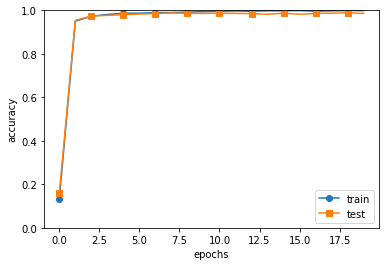

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


## 7.6 CNN 시각화하기  
### 7.6.1 1번째 층의 가중치 시각화하기

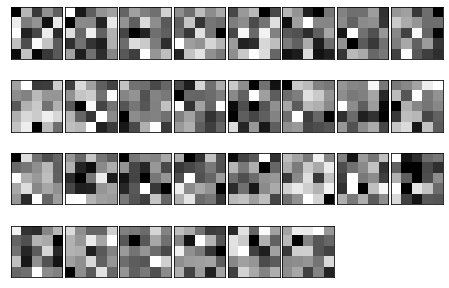

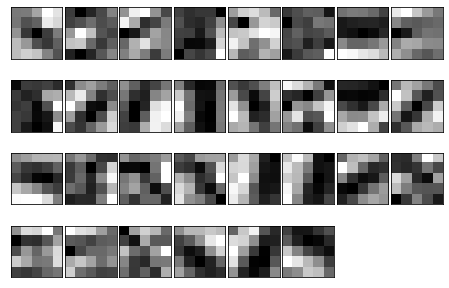

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from ch07.simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

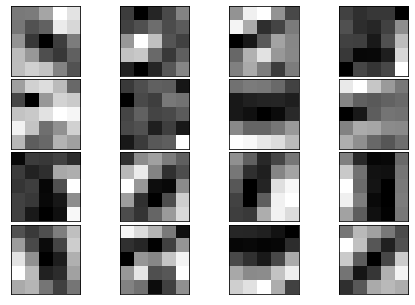

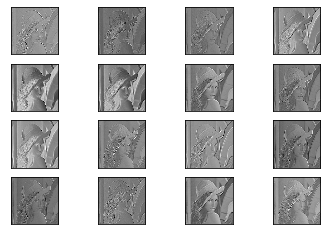

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from ch07.simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 학습된 가중치
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()


<img style="float: left;" src="equations_and_figures/fig%207-25.png" width="500">

### 7.6.2 층 깊이에 따른 추출 정보 변화  
계층이 깊어질수록 추출되는 정보는 더 추상화  
층이 깊어질수록 뉴런이 반응하는 대상이 단순한 모양에서 '고급'정보로 변화
<img style="float: left;" src="equations_and_figures/fig%207-26.png" width="650">

## 7.7 대표적인 CNN  
### 7.7.1 LeNet  
1998년에 제안된 첫 CNN  
합성곱 계층과 풀링 계층을 반복하고 마지막으로 완전연결계층을 거쳐 결과 출력  
LeNet은 시그모이드 함수를 사용하지만 현재는 주로 ReLU 사용  
LeNet은 서브샘플링을 사용하여 중간 데이터 크기를 줄이지만 현재는 최대 풀링이 주류  
<img style="float: left;" src="equations_and_figures/fig%207-27.png" width="700">

### 7.7.2 AlexNet  
2012년에 발표된 AlexNet은 딥러닝 열풍을 일으킴  
합성곱 계층과 풀링 계층을 거듭하며 완전연결 계층을 거쳐 결과 출력  
- 활성화 함수로 ReLU를 이용
- LRN (local response normalization)이라는 국소적 정규화를 실시하는 계층을 이용
- 드롭아웃을 사용

## 7.8 정리
- CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가
- 합성곱 계층과 풀링 계층은 im2col을 이용하면 간단하고 효율적으로 구현 가능
- CNN을 시각화해보면 계층이 깊어질수록 고급정보가 추출
- 대표적인 CNN에는 LeNet과 AlexNet
- 딥러닝의 발전에는 빅데이터와 GPU가 크게 기여